# Age Estimation CNN (VGG16, VGG-Face Transfer Learning)

In [1]:
import os
import numpy as np
from numpy import array
from numpy import argmax
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import glob
import keras
import time
from keras import backend as K
from keras.layers.core import Dense
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.utils import np_utils
from keras.applications import imagenet_utils
from keras.optimizers import SGD
from keras.callbacks import CSVLogger, EarlyStopping, TensorBoard, ModelCheckpoint 
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import random
from scipy.misc import imread, imresize

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import backend as K
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

%matplotlib inline



Using TensorFlow backend.


## Preprocessing

In [2]:
image_labels = pd.read_csv('train_target.csv')

In [13]:
#prepare data for flow_from_dir
from shutil import copyfile
data_size = len(image_labels.index)
train_size = data_size - (data_size * 0.2)
count = 0

for index, row in image_labels.iterrows():
    name = row['Id']
    age = str(row['Age']) 
    
    if count<train_size:
        
        if os.path.isdir('data/train/' + age):
            copyfile('train/'+name, 'data/train/'+age+'/'+name)
        else:
            os.makedirs('data/train/'+age)
            copyfile('train/'+name, 'data/train/'+age+'/'+name)

        count = count + 1


    else:
        if os.path.isdir('data/validation/' + age):
            copyfile('train/'+name, 'data/validation/'+age+'/'+name)
        else:
            os.makedirs('data/validation/'+age)
            copyfile('train/'+name, 'data/validation/'+age+'/'+name)
    

In [3]:
def plotImage(image):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[0].grid()
    axarr[0].set_title('Image')

In [12]:
X_train = []
Y_train = []
for index, row in image_labels.iterrows():
    image = imread('train/' + row[0], mode='RGB')
    image = imresize(image, (244,244,3))
    X_train.append(np.array(image))
    Y_train.append(row[1])

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [13]:
X_train = np.array(X_train)

In [14]:
Y_train = to_categorical(Y_train)

In [15]:
#Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=3)

49


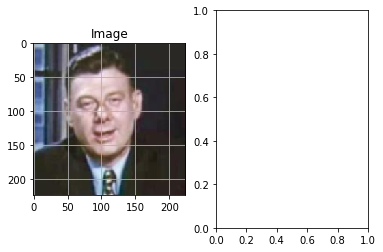

In [111]:
#Image and Ages
num = 1043
plotImage(X_train[num])
print(argmax(y_train[num]))

In [5]:
img_data = np.asarray( images )

In [16]:
num_classes = np.size(Y_train, 1)

## VGG-16 Model

In [170]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

image_input = Input(shape=(224,224,3))

model = VGG16(input_tensor=image_input, include_top = True, weights='imagenet')

for layer in model.layers:
    layer.trainable = False
    
model.summary()

AttributeError: 'InputLayer' object has no attribute 'outbound_nodes'

## VGG-Face Model

In [29]:
image_input = Input(shape=(224,224,3))
from keras_vggface.vggface import VGGFace
vgg_face_model = VGGFace(model = 'resnet50', include_top = False, weights='vggface', input_shape=((224,224,3)))
    
vgg_face_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_8[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [30]:
for layer in vgg_face_model.layers[:-31]:
    layer.trainable = False
    

In [31]:
LL = vgg_face_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(LL)
x = Dense(5000,name = 'fc8')(x)
x = Dropout(0.5)(x)
x = Dense(4096,name = 'fc9')(x)
out = Dense(107, activation='softmax',name='classifier')(x)
custom_vgg_face_model = Model(vgg_face_model.input, out)

In [32]:
custom_vgg_face_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_8[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [33]:
sgd = SGD(lr=1e-4, decay=1e-3, momentum=0.9)
custom_vgg_face_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224,224),  
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical')  

train_generator = test_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224,224),  
        batch_size=batch_size,
        color_mode="rgb",
        class_mode='categorical')


Found 22672 images belonging to 107 classes.
Found 22672 images belonging to 107 classes.


In [35]:
# fine-tune the model

custom_vgg_face_model.fit_generator(
        train_generator,
        steps_per_epoch=22681 // batch_size,
        epochs=75)

Epoch 1/75
1417/1417 [==============================] - 273s 192ms/step - loss: 4.4118 - acc: 0.0364
Epoch 2/75
 448/1417 [========>.....................] - ETA: 3:00 - loss: 3.9250 - acc: 0.0473

FileNotFoundError: [Errno 2] No such file or directory: 'data/train\\19\\train_6388.jpg'

In [ ]:
t=time.time()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
callback_list = [early_stop]

hist = custom_vgg_face_model.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test), epochs=75, callbacks = callback_list, verbose=1)
#print('Training time: %s' % (t - time.time()))


In [ ]:
custom_vgg_face_model.evaluate(img_data, Y_train)

In [ ]:
from keras.models import model_from_json
model_json = custom_vgg_face_model.to_json()
with open("vgg_face_trained.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
custom_vgg_face_model.save_weights("vgg_face_model_weights.h5")
print("Saved model to disk")

In [42]:
predictions = custom_vgg_face_model.predict(testing_data)

68
[[7.95898359e-07 9.21909032e-06 2.76886851e-07 ... 4.25720458e-07
  4.23317658e-07 1.27833914e-06]
 [4.97554765e-07 8.55011706e-07 3.68742548e-08 ... 1.11947955e-07
  1.34594146e-07 2.39334611e-07]
 [1.43019060e-11 9.71408856e-11 3.89333574e-12 ... 3.09132320e-12
  1.73338405e-12 1.27860795e-11]
 ...
 [4.97396613e-08 3.89313328e-07 2.03993746e-08 ... 2.91207751e-08
  1.88591063e-08 3.22944977e-08]
 [1.96029522e-08 5.75219623e-08 7.87872345e-09 ... 2.65869655e-08
  5.56511326e-09 7.15812263e-08]
 [1.02805495e-06 1.28216993e-06 5.61833986e-07 ... 6.89571834e-07
  1.68642316e-07 6.92823562e-07]]


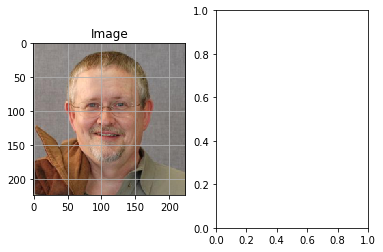

In [83]:
index = 208
print(argmax(predictions[index]))
print(predictions)
plotImage(testing_data[index])

In [64]:
from keras.models import load_model
from keras.models import model_from_json
json_file = open('vgg_face_trained.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [65]:
loaded_model.load_weights("vgg_face_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [66]:
pred = loaded_model.predict(testing_data)

22


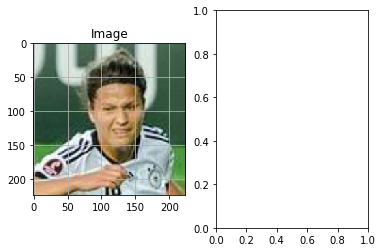

In [83]:
s = 4010
print(argmax(pred[s]))
plotImage(testing_data[s])

# VGG-FACE Exp 2

In [167]:
from keras_vggface.vggface import VGGFace
vgg_face_model_2 = VGGFace(model = 'resnet50',include_top = False, weights='vggface', input_shape=((244,244,3)))

for layer in vgg_face_model_2.layers:
    layer.trainable = False
    
vgg_face_model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 122, 122, 64) 9408        input_11[0][0]                   
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 122, 122, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_393 (Activation)     (None, 122, 122, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [41]:
LL = vgg_face_model_2.get_layer('avg_pool').output
x = Flatten(name='flatten')(LL)
x = Dense(5000, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc8')(x)
x = Dropout(0.5)(x)
x = Dense(4096,name = 'fc9')(x)
out = Dense(num_classes, activation='softmax',name='classifier')(x)
vgg_face_model_2 = Model(vgg_face_model_2.input, out)

In [42]:
vgg_face_model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_6[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_246 (Activation)     (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [43]:
sgd = SGD(lr=0.0005, decay=1e-3, momentum=0.95)
vgg_face_model_2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
t=time.time()

#X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

#ckpt_save = "ckpt_vgg_2_weights-{epoch:02d}.hdf5"
#checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, save_best_only=True)
filepath="vgg_face_weights_improvment-{epoch:02d}-{val_acc:.2f}.hdf5"
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#tensorboard = TensorBoard(log_dir=".", histogram_freq=2000, write_graph=True, write_images=False)
callback_list = [early_stop, checkpoint]

hist = vgg_face_model_2.fit(X_train, y_train, batch_size=16, validation_data=(X_test, y_test), epochs=75, callbacks = callback_list, verbose=1)
print('Training time: %s' % (t - time.time()))

Train on 21263 samples, validate on 7088 samples
Epoch 1/75
21263/21263 [==============================] - 190s 9ms/step - loss: 4.2441 - acc: 0.0384 - val_loss: 3.9175 - val_acc: 0.0466

Epoch 00001: val_acc improved from -inf to 0.04656, saving model to vgg_face_weights_improvment-01-0.05.hdf5
Epoch 2/75
21263/21263 [==============================] - 183s 9ms/step - loss: 3.7670 - acc: 0.0594 - val_loss: 3.8090 - val_acc: 0.0464

Epoch 00002: val_acc did not improve from 0.04656
Epoch 3/75
21263/21263 [==============================] - 183s 9ms/step - loss: 3.6506 - acc: 0.0747 - val_loss: 3.7998 - val_acc: 0.0506

Epoch 00003: val_acc improved from 0.04656 to 0.05065, saving model to vgg_face_weights_improvment-03-0.05.hdf5
Epoch 4/75
21263/21263 [==============================] - 184s 9ms/step - loss: 3.5758 - acc: 0.0873 - val_loss: 3.8103 - val_acc: 0.0453

Epoch 00004: val_acc did not improve from 0.05065
Epoch 5/75
 6976/21263 [========>.....................] - ETA: 1:36 - loss

KeyboardInterrupt: 

In [51]:
K.clear_session()
del custom_vgg_face_model_2

# VGG16 Model

In [14]:

last_layer = model.get_layer('fc2').output
out = Dense(num_classes, activation='softmax', name='predictions')(model.layers[-2].output)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14857954257887966867
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5437939712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11852011504867941774
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [14]:
t=time.time()
#	t = now()
hist = custom_vgg_model.fit(img_data, Y_train, batch_size=50, epochs=35, verbose=1)
print('Training time: %s' % (t - time.time()))

Epoch 1/100
28351/28351 [==============================] - 143s 5ms/step - loss: 15.4641 - acc: 0.0393
Epoch 2/100
28351/28351 [==============================] - 137s 5ms/step - loss: 15.4814 - acc: 0.0395
Epoch 3/100
28351/28351 [==============================] - 137s 5ms/step - loss: 15.4814 - acc: 0.0395
Epoch 4/100
28351/28351 [==============================] - 137s 5ms/step - loss: 15.4814 - acc: 0.0395
Epoch 5/100
28351/28351 [==============================] - 137s 5ms/step - loss: 15.4814 - acc: 0.0395
Epoch 6/100
28351/28351 [==============================] - 137s 5ms/step - loss: 15.4814 - acc: 0.0395
Epoch 7/100
28351/28351 [==============================] - 137s 5ms/step - loss: 15.4814 - acc: 0.0395
Epoch 8/100
28351/28351 [==============================] - 137s 5ms/step - loss: 15.4814 - acc: 0.0395
Epoch 9/100
28351/28351 [==============================] - 137s 5ms/step - loss: 15.4814 - acc: 0.0395
Epoch 10/100
28351/28351 [==============================] - 138s 5ms/step

KeyboardInterrupt: 

In [47]:
X_test = []
for file2 in glob.glob('test/*.jpg'):
    X_test.append(file2)

import re
X_test_sorted = sorted(X_test, key=lambda x: (int(re.sub('\D','',x)),x))

testing_images = []

for im in X_test_sorted:
        image2 = imread(im, mode='RGB')
        image3 = imresize(image2, (224,224,3))
        testing_images.append(np.asarray(image3))

C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\user\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


In [48]:
testing_data = np.asarray(testing_images)

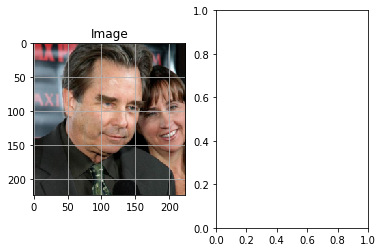

In [168]:
predictions = custom_vgg_model.predict(testing_data)

53
[[1.4923729e-38 1.1908730e-37 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.3046717e-33]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 8.5570313e-38 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.1521737e-36]
 ...
 [1.2305516e-27 2.7202750e-26 3.3234077e-31 ... 1.3348837e-29
  9.1541971e-31 4.5384265e-28]
 [1.4192844e-37 5.8295386e-36 3.1381821e-38 ... 2.4616279e-38
  7.2372795e-38 1.2049826e-35]
 [2.0940379e-35 2.0299361e-35 4.4372351e-37 ... 2.4194978e-36
  2.4251530e-36 9.1185382e-33]]


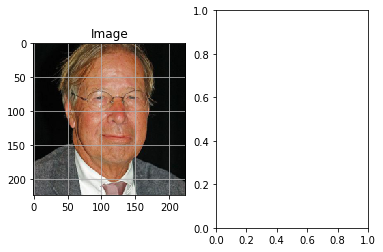

In [182]:
print(argmax(predictions[1619]))
print(predictions)
plotImage(testing_data[1619])

In [ ]:
print(argmax(Y_train[4]))

In [167]:
from keras.models import model_from_json
model_json = custom_vgg_model.to_json()
with open("model_correct_trained.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("custom_vgg_model.h5")
print("Saved model to disk")

Saved model to disk


In [49]:
print(testing_data.shape)

(7090, 224, 224, 3)


In [55]:
file_names = []
ages = []
counter = 0
for file2 in os.listdir('test'):
    file_names.append(os.path.basename(file2))
    ages.append(argmax(predictions[counter]))
    counter= counter+1
    
ordered_files = sorted(file_names, key=lambda x: (int(re.sub('\D','',x)),x))

files = pd.DataFrame(ordered_files)  
age = pd.DataFrame(ages) 

In [56]:
result = pd.concat([files, age],axis=1)
result.columns = ['Id', 'Expected']

In [57]:
result.to_csv('answers_vgg_face_1.csv')

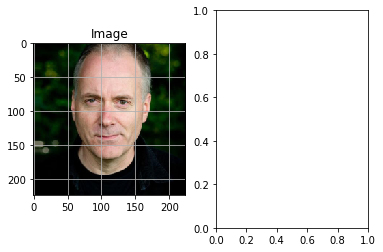

In [151]:
plotImage(img_data[2])

In [152]:
print(argmax(Y_train[2]))

53


In [44]:
plotImage(testing_data[0])

NameError: name 'plotImage' is not defined